<a href="https://colab.research.google.com/github/katoro8989/Kaggle/blob/signate/SIGNATE_student_cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import log_loss
# from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
import xgboost as xgb
# from tabpfn import TabPFNClassifier
from sklearn.base import BaseEstimator
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE




# get datasets
train = pd.read_csv('/content/drive/MyDrive/SIGNATE/train.csv')
test = pd.read_csv('/content/drive/MyDrive/SIGNATE/test.csv')
sample = pd.read_csv('/content/drive/MyDrive/SIGNATE/submit_sample.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27532 entries, 0 to 27531
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            27532 non-null  int64 
 1   region        27532 non-null  object
 2   year          27532 non-null  int64 
 3   manufacturer  27532 non-null  object
 4   condition     27532 non-null  object
 5   cylinders     27532 non-null  object
 6   fuel          26293 non-null  object
 7   odometer      27532 non-null  int64 
 8   title_status  27076 non-null  object
 9   transmission  27532 non-null  object
 10  drive         27532 non-null  object
 11  size          27532 non-null  object
 12  type          27076 non-null  object
 13  paint_color   27532 non-null  object
 14  state         24228 non-null  object
 15  price         27532 non-null  int64 
dtypes: int64(4), object(12)
memory usage: 3.4+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27537 entries, 0 to 27536
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            27537 non-null  int64 
 1   region        27537 non-null  object
 2   year          27537 non-null  int64 
 3   manufacturer  27537 non-null  object
 4   condition     27537 non-null  object
 5   cylinders     27537 non-null  object
 6   fuel          26042 non-null  object
 7   odometer      27537 non-null  int64 
 8   title_status  27308 non-null  object
 9   transmission  27537 non-null  object
 10  drive         27537 non-null  object
 11  size          27537 non-null  object
 12  type          27308 non-null  object
 13  paint_color   27537 non-null  object
 14  state         24508 non-null  object
dtypes: int64(3), object(12)
memory usage: 3.2+ MB


In [ ]:
train.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [ ]:
test.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1495
odometer           0
title_status     229
transmission       0
drive              0
size               0
type             229
paint_color        0
state           3029
dtype: int64

# year

In [ ]:
def bar_plot(variable, data):
    """
        input: variable ex: "Sex"
        output: bar plot & value count
    """
    # get feature
    var = data[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()

    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    # plt.xticks(varValue.index, varValue.index.values)
    plt.xticks(varValue.index[::5], varValue.index.values[::5], fontsize=5)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))


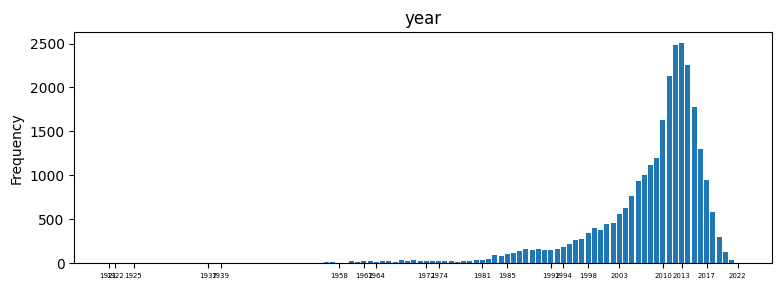

year: 
 2013    2503
2012    2482
2014    2252
2011    2127
2015    1776
        ... 
1931       1
1932       1
1929       1
1921       1
1945       1
Name: year, Length: 97, dtype: int64


In [ ]:
bar_plot('year', train)

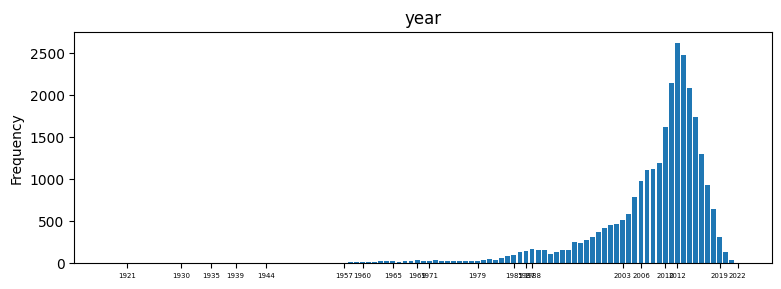

year: 
 2012    2621
2013    2484
2011    2143
2014    2086
2015    1740
        ... 
1921       1
1926       1
1943       1
1929       1
1933       1
Name: year, Length: 100, dtype: int64


In [ ]:
bar_plot('year', test)

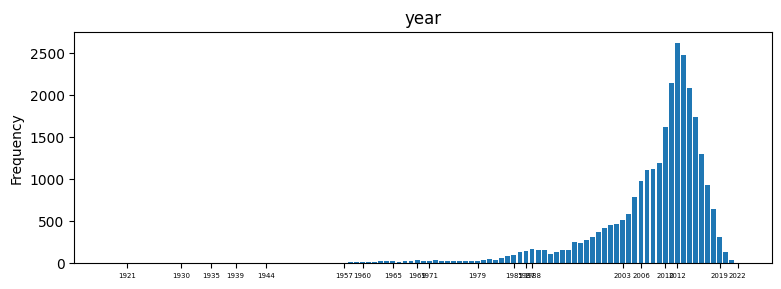

year: 
 2012    2621
2013    2484
2011    2143
2014    2086
2015    1740
        ... 
1921       1
1926       1
1943       1
1929       1
1933       1
Name: year, Length: 100, dtype: int64


In [ ]:
bar_plot('year', test)

# odometer

In [ ]:
train[train["odometer"]>1000000]

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
1775,1775,flint,2005,chevrolet,excellent,4 cylinders,diesel,2946000,clean,automatic,4wd,mid-size,SUV,red,mi,8751
4372,4372,olympic peninsula,2013,volkswagen,excellent,4 cylinders,gas,1127500,NaN,automatic,fwd,compact,NaN,black,wa,8558
6829,6829,green bay,2012,ram,excellent,6 cylinders,diesel,1233280,lien,manual,4wd,full-size,pickup,green,wi,35135
6925,6925,phoenix,2012,FORD,excellent,8 cylinders,gas,1187840,clean,automatic,rwd,full-size,truck,black,NaN,16796
10576,10576,baltimore,2001,acura,good,6 cylinders,gas,1638440,clean,automatic,rwd,mid-size,SUV,custom,md,2289
12549,12549,odessa / midland,1993,bmw,excellent,6 cylinders,NaN,1484310,clean,automatic,fwd,full-size,sedan,white,tx,5372


In [ ]:
train[train["odometer"]<0]

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
44,44,rochester,2008,jeep,fair,6 cylinders,gas,-1,clean,automatic,4wd,full-size,SUV,black,ny,5077
211,211,inland empire,1973,chevrolet,good,8 cylinders,gas,-1,clean,manual,rwd,full-size,coupe,black,ca,6335
276,276,baltimore,2010,bmw,good,6 cylinders,gas,-1,clean,automatic,fwd,mid-size,sedan,brown,md,5858
583,583,rhode island,2010,jeep,excellent,6 cylinders,gas,-1,clean,automatic,4wd,compact,SUV,blue,ri,5122
611,611,merced,2017,subaru,like new,4 cylinders,gas,-1,clean,automatic,4wd,mid-size,wagon,black,NaN,16132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27036,27036,medford-ashland,2006,ford,excellent,6 cylinders,gas,-1,clean,automatic,4wd,full-size,pickup,green,or,33169
27138,27138,denver,2011,chevrolet,excellent,6 cylinders,gas,-1,clean,automatic,fwd,full-size,pickup,brown,co,20063
27207,27207,tallahassee,2018,bmw,like new,4 cylinders,gas,-1,clean,automatic,rwd,mid-size,sedan,black,fl,19580
27389,27389,orange county,2011,ford,like new,6 cylinders,gas,-1,rebuilt,other,rwd,mid-size,coupe,black,NaN,7921


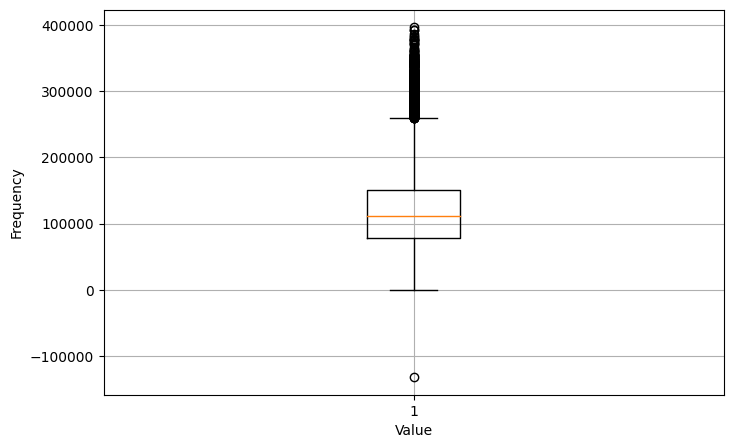

In [ ]:
plt.figure(figsize=(8, 5))
plt.boxplot(train['odometer'])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
train['odometer'].describe()

count     27532.000000
mean     115705.469817
std       59968.579773
min     -131869.000000
25%       78367.750000
50%      111444.500000
75%      150837.000000
max      396512.000000
Name: odometer, dtype: float64

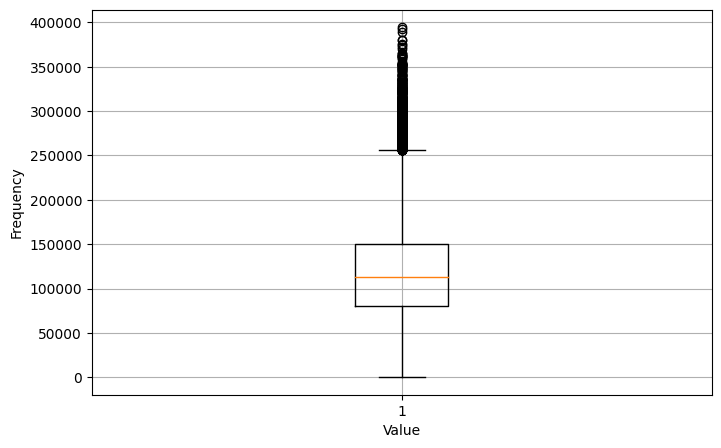

In [ ]:
plt.figure(figsize=(8, 5))
plt.boxplot(test['odometer'])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


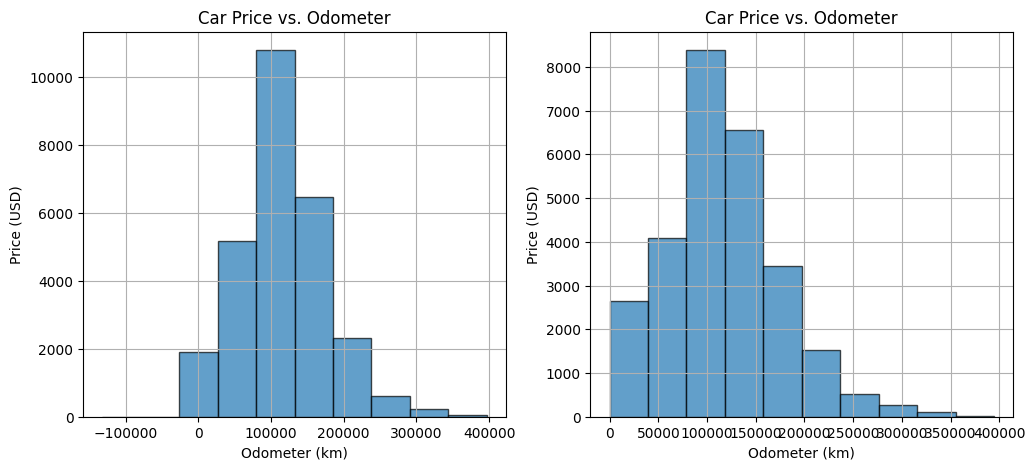

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(train[train["odometer"]<1000000]['odometer'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Odometer (km)')
plt.ylabel('Price (USD)')
plt.title('Car Price vs. Odometer')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.hist(test['odometer'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Odometer (km)')
plt.ylabel('Price (USD)')
plt.title('Car Price vs. Odometer')
plt.grid(True)
plt.show()

# region

In [ ]:
# region列の出現頻度をカウント
value_counts = train['region'].value_counts()

# 出現頻度が1回のものをotherに置換
rare_items = value_counts[value_counts == 1].index
train['region'] = train['region'].replace(rare_items, 'other')

<ipython-input-25-2bdeed10abe4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train[train['region'].value_counts()==1]


IndexingError: ignored

In [ ]:
train['region'].value_counts()[0:20]

central NJ             1069
rhode island            712
rochester               522
albany                  504
washington, DC          477
las vegas               429
tampa bay area          414
los angeles             384
richmond                353
dallas / fort worth     332
pittsburgh              321
new york city           298
tucson                  291
philadelphia            283
north jersey            261
phoenix                 259
knoxville               257
baltimore               252
albuquerque             249
detroit metro           248
Name: region, dtype: int64

In [ ]:
test['region'].value_counts()[0:20]

central NJ             1097
rhode island            723
rochester               531
albany                  530
washington, DC          484
las vegas               466
los angeles             419
tampa bay area          419
richmond                332
new york city           328
dallas / fort worth     314
pittsburgh              306
tucson                  280
philadelphia            278
detroit metro           273
north jersey            269
stockton                262
syracuse                257
albuquerque             253
denver                  251
Name: region, dtype: int64

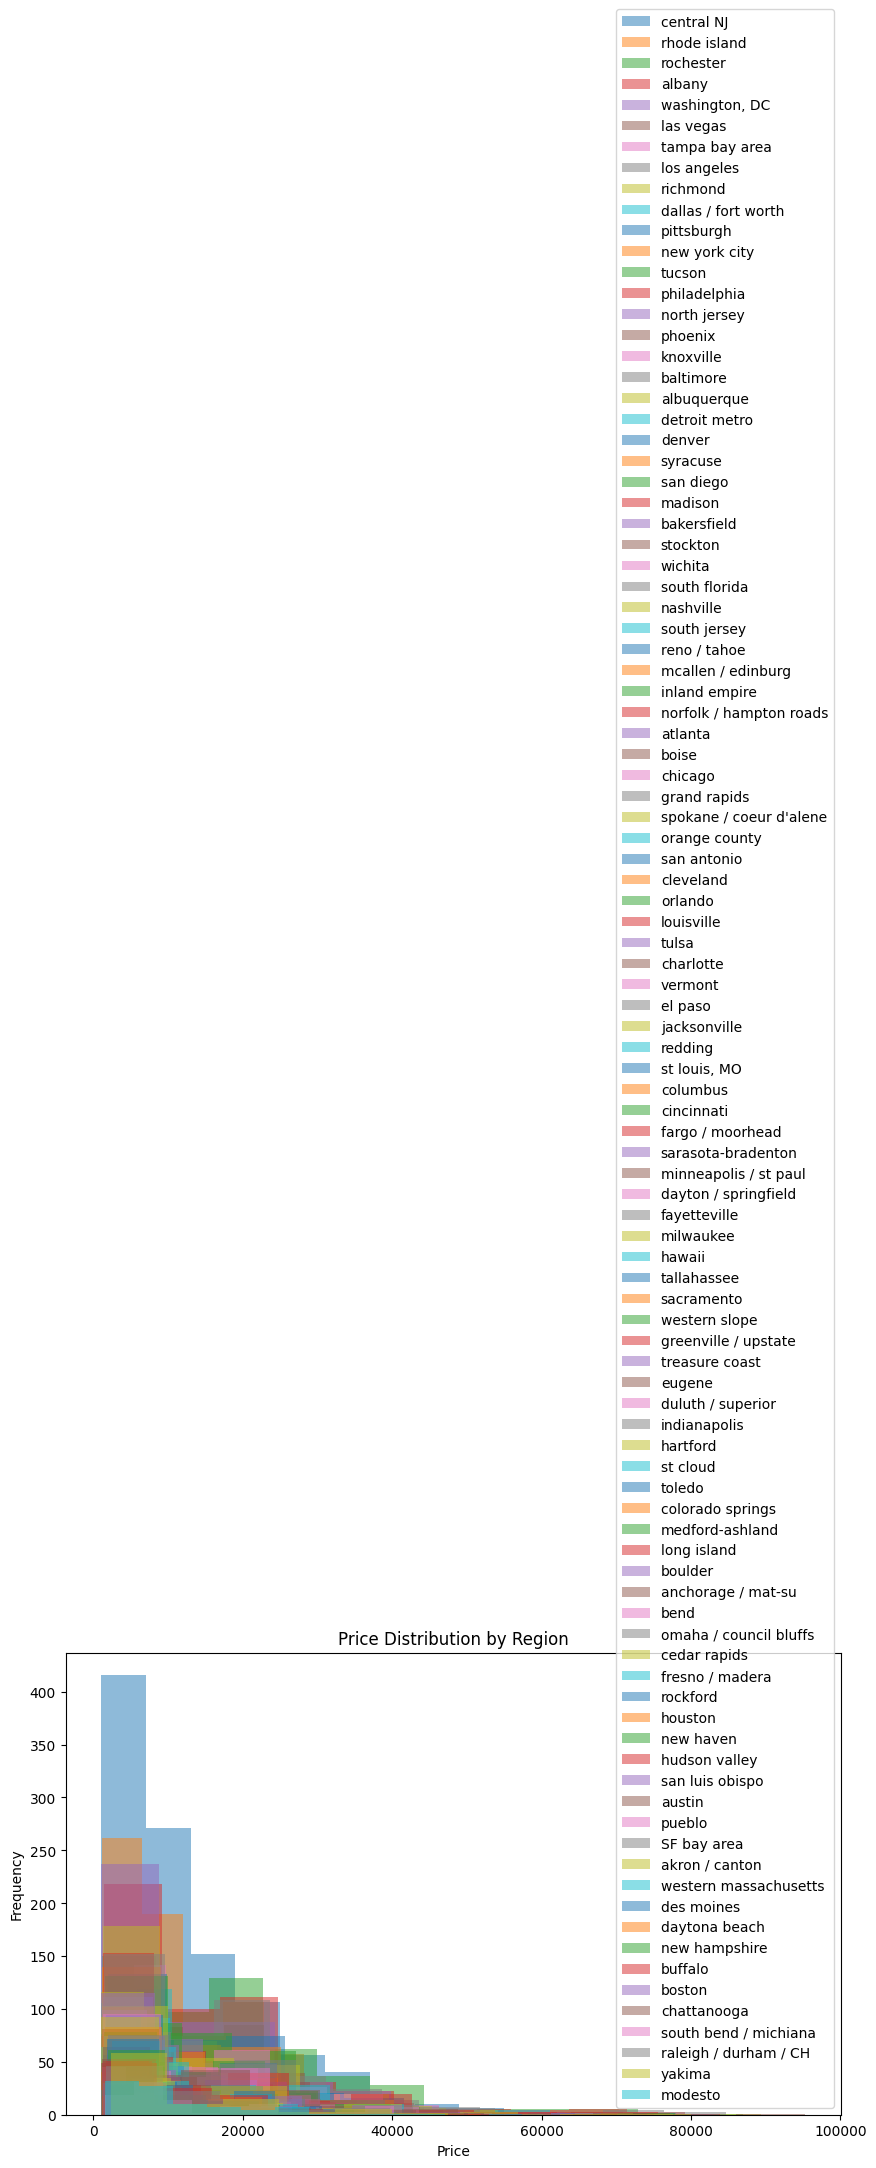

In [ ]:
region_counts = train['region'].value_counts()
sorted_regions = region_counts.index.tolist()
plt.figure(figsize=(10, 6))

for region in sorted_regions[0:100]:
    prices = train[train['region'] == region]['price']
    plt.hist(prices, bins=10, alpha=0.5, label=region)

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution by Region')
plt.legend()
plt.show()

In [ ]:
price_stats = train.groupby('region')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats["mean"]

0      14584.000000
1       8028.583333
2      12551.647059
3      15586.365079
4      10753.546185
           ...     
367    16479.416667
368    11982.666667
369    12089.378788
370     9217.647059
371     5490.666667
Name: mean, Length: 372, dtype: float64

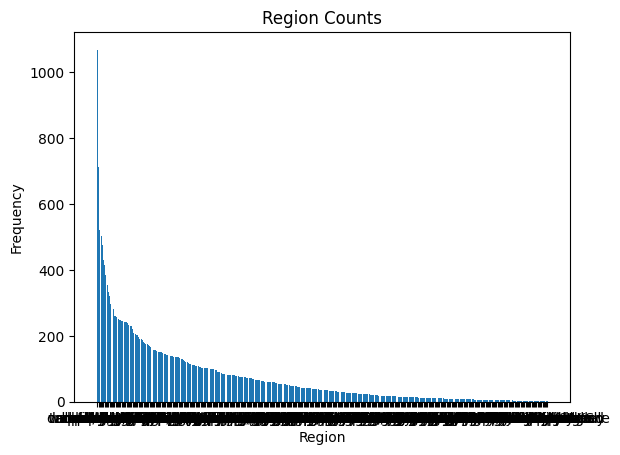

In [ ]:
# region列のユニークな項目の出現頻度を調べる
region_counts = train['region'].value_counts()

# ヒストグラムプロット
plt.bar(region_counts.index, region_counts)
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.title('Region Counts')
plt.show()

In [ ]:


trainp = train

# カテゴリごとのpriceの平均値を計算
price_mean_by_region = trainp.groupby('region')['price'].mean().reset_index()

# priceの平均値が高い順にラベルを付与
price_mean_by_region = price_mean_by_region.sort_values(by='price', ascending=False)
price_mean_by_region['region_label'] = range(len(price_mean_by_region))

# ラベルを元のデータにマージ
trainp = trainp.merge(price_mean_by_region[['region', 'region_label']], on='region', how='left')

print(trainp[["region", "price", "region_label"]].head(30))


                      region  price  region_label
0                  nashville  27587            91
1              state college   4724           339
2                    wichita  10931           200
3                     albany  16553            72
4                    redding   5158           308
5   florence / muscle shoals   7941           350
6               oregon coast   5860           241
7            medford-ashland   2799           100
8                   richmond   6036           143
9                    buffalo   7341           230
10                  billings  10880            26
11               bakersfield   5757           121
12                central NJ  11039           186
13                    albany   8760            72
14    worcester / central MA  17244           191
15                eau claire   3389            27
16                   wichita   3963           200
17      greenville / upstate  36783             0
18                    yakima   3289           122


In [ ]:

trainp = train

# カウントエンコーディングを行う
count_encoding = trainp['region'].value_counts()
trainp['region_count_encoding'] = trainp['region'].map(count_encoding)

# priceの高さに応じた順序を考慮して数値を足す
price_order = trainp.groupby('region')['price'].mean().sort_values().reset_index()
price_order['order'] = range(len(price_order))
trainp = trainp.merge(price_order, on='region', how='left')
trainp['region_count_encoding'] += trainp['order'] / 1000

# 不要な列を削除
trainp.drop(['order'], axis=1, inplace=True)

print(trainp[['region', 'region_encoded']])

              region  region_encoded
0          nashville            2.20
1      state college            0.32
2            wichita            0.00
3             albany            0.00
4            redding            0.00
...              ...             ...
27527   williamsport            2.03
27528          tulsa            0.00
27529      rochester            0.00
27530      rochester            0.00
27531  orange county            0.00

[27532 rows x 2 columns]


# manufacturer

In [ ]:
train["manufacturer"].value_counts()

ford             6166
chevrolet        3339
bmw              2736
toyota           1570
honda            1526
                 ... 
SΑTURN              1
ＤＯＤＧＥ               1
ｉｎｆｉｎｉｔｉ            1
ｍｅｒｃｅｄｅｓ－ｂｅｎｚ       1
ᴄhrysler            1
Name: manufacturer, Length: 125, dtype: int64

In [ ]:
test["manufacturer"].value_counts()

ford            6169
chevrolet       3316
bmw             2865
honda           1608
toyota          1555
                ... 
ＮＩＳＳＡＮ             1
ＣＡＤＩＬＬＡＣ           1
ｓａｔｕｒｎ             1
aston-martin       1
аcura              1
Name: manufacturer, Length: 125, dtype: int64

In [ ]:
train["manufacturer"].unique()

array(['bmw', 'toyota', 'ford', 'nissan', 'volkswagen', 'FORD', 'lexus',
       'buick', 'subaru', 'ram', 'TOYOTA', 'dodge', 'ｂｍｗ', 'chevrolet',
       'RAM', 'BMW', 'jeep', 'ｃｈｅｖｒｏｌｅｔ', 'honda', 'NISSAN', 'hyundai',
       'chrysler', 'gmc', 'mazda', 'audi', 'lincoln', 'kia',
       'mercedes-benz', 'mitsubishi', 'CHEVROLET', 'GMC', 'ｆｏｒｄ', 'BUICK',
       'saturn', 'infiniti', 'MINI', 'mercury', 'cadillac',
       'MERCEDES-BENZ', 'pontiac', 'acura', 'HONDA', 'ACURA', 'KIA',
       'fiat', 'jaguar', 'ｒａｍ', 'mini', 'LEXUS', 'VOLKSWAGEN', 'ｋｉａ',
       'SUBARU', 'ｎｉｓｓａｎ', 'DODGE', 'volvo', 'HYUNDAI', 'MAZDA', 'ｈｏｎｄａ',
       'ｍａｚｄａ', 'INFINITI', 'CADILLAC', 'JEEP', 'LINCOLN', 'ｔｏｙｏｔａ',
       'niѕsan', 'AUDI', 'ＶＯＬＫＳＷＡＧＥＮ', 'ＣＨＥＶＲＯＬＥＴ', 'MERCURY', 'ｂｕｉｃｋ',
       'ROVER', 'ｄｏｄｇｅ', 'porsche', 'ｖｏｌｖｏ', 'ｖｏｌｋｓｗａｇｅｎ', 'JAGUAR',
       'SATURN', 'ｊｅｅｐ', 'rover', 'ｓｕｂａｒｕ', 'CHRYSLER', 'PONTIAC',
       'ｍｉｔｓｕｂｉｓｈｉ', 'ＴＯＹＯＴＡ', 'ＢＭＷ', 'ｃｈｒｙｓｌｅｒ', 'nisѕan', 'MITSUBISHI',
       'ｈｙｕｎｄａｉ', 'ｇｍｃ'

In [ ]:
import unicodedata

df['manufacturer'] = df['manufacturer'].str.replace(' ', '')
df['manufacturer'] = df['manufacturer'].apply(lambda x: unicodedata.normalize('NFKC', x))
df['manufacturer'] = df['manufacturer'].str.lower()
df.loc[df["manufacturer"] == "niѕsan", "manufacturer"] = "nissan"
df.loc[df["manufacturer"] == "nisѕan", "manufacturer"] = "nissan"
df.loc[df["manufacturer"] == "subαru", "manufacturer"] = "subaru"
df.loc[df["manufacturer"] == "toyotа", "manufacturer"] = "toyota"
df.loc[df["manufacturer"] == "sαturn", "manufacturer"] = "saturn"
df.loc[df["manufacturer"] == "аcura", "manufacturer"] = "acura"
df.loc[df["manufacturer"] == "vоlkswagen", "manufacturer"] = "volkswagen"
df.loc[df["manufacturer"] == "lexuѕ", "manufacturer"] = "lexus"
df.loc[df["manufacturer"] == "ᴄhrysler", "manufacturer"] = "chrysler"

df["manufacturer"].unique()

array(['bmw', 'toyota', 'ford', 'nissan', 'volkswagen', 'lexus', 'buick',
       'subaru', 'ram', 'dodge', 'chevrolet', 'jeep', 'honda', 'hyundai',
       'chrysler', 'gmc', 'mazda', 'audi', 'lincoln', 'kia',
       'mercedes-benz', 'mitsubishi', 'saturn', 'infiniti', 'mini',
       'mercury', 'cadillac', 'pontiac', 'acura', 'fiat', 'jaguar',
       'volvo', 'rover', 'porsche', 'landrover', 'aston-martin',
       'alfa-romeo'], dtype=object)

In [ ]:
price_stats = train.groupby('manufacturer')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats

,manufacturer,mean,median,min,max,std
0,ACURA,5524.958333,5720.5,1182,12789,3095.674717
1,AUDI,15155.928571,15027.5,4806,27933,6567.243618
2,BMW,13784.422053,9763.0,2008,73208,10099.333280
3,BUICK,13196.675000,9571.0,1154,68300,11109.152660
4,CADILLAC,10455.115385,8123.0,2107,27009,5796.258872
...,...,...,...,...,...,...
120,ｓａｔｕｒｎ,4451.000000,4451.0,4451,4451,NaN
121,ｓｕｂａｒｕ,15848.500000,16645.0,6814,23290,6960.802516
122,ｔｏｙｏｔａ,9497.517241,7147.0,1844,31687,6777.683926
123,ｖｏｌｋｓｗａｇｅｎ,8628.375000,7926.0,5047,15150,3342.823740


# condition

In [ ]:
train["condition"].value_counts()

excellent    15219
good          6009
like new      3810
fair          2404
new             55
salvage         35
Name: condition, dtype: int64

In [ ]:
test["condition"].value_counts()

excellent    15221
good          6011
like new      3837
fair          2369
new             61
salvage         38
Name: condition, dtype: int64

In [ ]:
price_stats = train.groupby('condition')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats

,condition,mean,median,min,max,std
0,excellent,14662.392076,11531.0,1052,96818,10908.606503
1,fair,7210.345674,4899.0,1005,68283,7006.320476
2,good,11022.550674,7396.0,1004,84636,9615.826190
3,like new,16511.362730,13553.5,1080,89408,12791.353296
4,new,16274.418182,10499.0,2940,60771,13359.174242
5,salvage,8640.685714,4598.0,1161,39644,9064.321174


# cylinders

In [ ]:
train["cylinders"].value_counts()

6 cylinders     11504
4 cylinders     10071
8 cylinders      5727
other              71
10 cylinders       60
5 cylinders        46
3 cylinders        31
12 cylinders       22
Name: cylinders, dtype: int64

In [ ]:
test["cylinders"].value_counts()

6 cylinders     11697
4 cylinders      9998
8 cylinders      5613
other              78
5 cylinders        61
10 cylinders       57
3 cylinders        24
12 cylinders        9
Name: cylinders, dtype: int64

In [ ]:
price_stats = train.groupby('cylinders')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats

,cylinders,mean,median,min,max,std
0,10 cylinders,19698.116667,18646.5,1247,63450,12109.325545
1,12 cylinders,18095.818182,17807.0,4741,37359,8965.490147
2,3 cylinders,16942.419355,14473.0,2263,71508,15414.703022
3,4 cylinders,10552.900407,7911.0,1007,78749,7795.703857
4,5 cylinders,14089.347826,9305.0,4599,45490,10473.333487
5,6 cylinders,14480.490786,10117.0,1004,95329,11402.860403
6,8 cylinders,16443.964903,14152.0,1005,96818,13296.908169
7,other,14523.929577,8765.0,1438,72102,14407.153411


# fuel

In [ ]:
train["fuel"].value_counts()

gas         23546
diesel       2639
hybrid         79
other          18
electric       11
Name: fuel, dtype: int64

In [ ]:
test["fuel"].value_counts()

gas         23427
diesel       2515
hybrid         65
other          21
electric       14
Name: fuel, dtype: int64

In [ ]:
price_stats = train.groupby('fuel')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats

,fuel,mean,median,min,max,std
0,diesel,24804.856006,21737.0,1027,96818,15928.644624
1,electric,18257.636364,19001.0,1840,36516,13991.189530
2,gas,12251.696042,8574.0,1004,84636,9521.647973
3,hybrid,9789.607595,7037.0,1175,30457,7394.501874
4,other,14483.388889,9096.5,1978,57149,14553.926623


# title_status

In [ ]:
train["title_status"].value_counts()

clean         22365
rebuilt        3004
salvage         985
lien            465
parts only      133
missing         124
Name: title_status, dtype: int64

In [ ]:
test["title_status"].value_counts()

clean         22716
rebuilt        2959
salvage         938
lien            420
parts only      157
missing         118
Name: title_status, dtype: int64

In [ ]:
price_stats = train.groupby('title_status')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats

,title_status,mean,median,min,max,std
0,clean,13276.948312,8959.0,1004,96818,10979.958397
1,lien,17082.879570,14832.0,1083,81011,12411.808968
2,missing,9365.072581,5520.0,1080,55442,9369.456615
3,parts only,11581.669173,7421.0,1489,52345,9791.184545
4,rebuilt,14823.253329,11849.5,1156,86915,10457.320638
5,salvage,12351.056853,8753.0,1008,67982,10028.630372


# transmission

In [ ]:
train["transmission"].value_counts()

automatic    20497
manual        6156
other          879
Name: transmission, dtype: int64

In [ ]:
test["transmission"].value_counts()

automatic    20493
manual        6176
other          868
Name: transmission, dtype: int64

In [ ]:
price_stats = train.groupby('transmission')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats

,transmission,mean,median,min,max,std
0,automatic,13944.440064,9782.0,1004,96818,11074.134287
1,manual,12058.838856,7897.0,1005,81520,10644.009769
2,other,12249.751991,8423.0,1285,69664,9503.432942


# drive

In [ ]:
train["drive"].value_counts()

fwd    14602
4wd     8096
rwd     4834
Name: drive, dtype: int64

In [ ]:
test["drive"].value_counts()

fwd    14611
4wd     8006
rwd     4920
Name: drive, dtype: int64

In [ ]:
price_stats = train.groupby('drive')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats

,drive,mean,median,min,max,std
0,4wd,18647.268281,17376.0,1005,96818,13341.583334
1,fwd,9810.263663,7424.0,1004,71461,7289.242518
2,rwd,15846.747621,14473.5,1024,82319,11613.024346


# size

In [ ]:
train["size"].value_counts()

full-size      14585
mid-size        9371
compact         3352
sub-compact      132
fullーsize         42
midーsize          35
full−size          9
mid−size           5
subーcompact        1
Name: size, dtype: int64

In [ ]:
test["size"].value_counts()

full-size      14663
mid-size        9338
compact         3297
sub-compact      148
fullーsize         41
midーsize          28
full−size         16
mid−size           5
subーcompact        1
Name: size, dtype: int64

In [ ]:
test["size"].unique()

array(['full-size', 'mid-size', 'compact', 'sub-compact', 'midーsize',
       'fullーsize', 'mid−size', 'full−size', 'subーcompact'], dtype=object)

In [ ]:
price_stats = train.groupby('size')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()

price_stats

,size,mean,median,min,max,std
0,compact,8873.068317,7066.0,1033,58066,6447.490834
1,full-size,15399.474049,11800.0,1005,96818,12562.875051
2,full−size,16147.666667,17185.0,5008,35326,10731.666460
3,fullーsize,13723.880952,13383.0,1131,38727,8545.850165
4,mid-size,12159.247572,8962.0,1004,81011,8697.817730
5,mid−size,15042.800000,19588.0,2708,23641,9839.881844
6,midーsize,11521.771429,8012.0,2126,34822,8404.071500
7,sub-compact,10030.439394,6874.5,1082,37764,8167.070723
8,subーcompact,8543.000000,8543.0,8543,8543,NaN


# type

In [ ]:
test["type"].value_counts()

sedan          9476
SUV            7255
truck          3788
coupe          2334
pickup         2131
hatchback       669
van             543
convertible     461
mini-van        245
wagon           202
other           112
offroad          76
bus              16
Name: type, dtype: int64

In [ ]:
test["type"].value_counts()

sedan          9476
SUV            7255
truck          3788
coupe          2334
pickup         2131
hatchback       669
van             543
convertible     461
mini-van        245
wagon           202
other           112
offroad          76
bus              16
Name: type, dtype: int64

In [ ]:
price_stats = train.groupby('type')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
price_stats = price_stats.sort_values(by='mean', ascending=False)

price_stats

,type,mean,median,min,max,std
10,truck,20267.473808,18200.0,1024,95329,14693.884458
8,pickup,19205.355996,18128.5,1005,89408,13882.326294
1,bus,14763.421053,14125.0,2468,35094,9310.651954
11,van,14566.636872,11241.0,1533,78096,10722.521029
6,offroad,14390.645570,14586.0,1367,39589,10169.414200
0,SUV,13821.113801,9945.0,1004,96818,10097.081690
2,convertible,13664.002392,11560.0,1033,51198,9029.270108
7,other,11740.000000,7791.0,1080,45191,9352.729798
3,coupe,11654.478936,8198.0,1020,72908,9204.459138
5,mini-van,10947.061135,6994.0,1259,39924,9526.914354


In [ ]:
price_stats["type"].tolist()

['truck',
 'pickup',
 'bus',
 'van',
 'offroad',
 'SUV',
 'convertible',
 'other',
 'coupe',
 'mini-van',
 'sedan',
 'hatchback',
 'wagon']

# paint_color

In [ ]:
train["paint_color"].value_counts()

black     10143
silver     4300
blue       3765
white      3624
green      2385
red        1419
grey       1136
brown       365
custom      197
orange      144
yellow       30
purple       24
Name: paint_color, dtype: int64

In [ ]:
test["paint_color"].value_counts()

black     10081
silver     4369
blue       3858
white      3639
green      2285
red        1413
grey       1120
brown       387
custom      202
orange      125
yellow       34
purple       24
Name: paint_color, dtype: int64

In [ ]:
price_stats = train.groupby('paint_color')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
price_stats = price_stats.sort_values(by='mean', ascending=False)

price_stats

,paint_color,mean,median,min,max,std
10,white,16884.879139,14921.0,1037,86915,12627.539902
0,black,14798.718624,11206.0,1007,89408,11418.455284
11,yellow,14246.400000,8500.5,1652,66270,13212.806469
3,custom,13573.994924,9065.0,1509,62933,11112.440210
1,blue,13542.542629,9376.0,1131,81032,10742.219399
5,grey,12168.864437,8420.5,1098,55223,8935.320975
8,red,11811.757576,7874.0,1082,96818,10311.951609
9,silver,11324.398140,7844.0,1005,95329,9348.458584
6,orange,11200.854167,8004.5,1027,40892,7633.816317
7,purple,11157.708333,6260.0,1043,43182,10501.627172


In [ ]:
price_stats["paint_color"].tolist()

['white',
 'black',
 'yellow',
 'custom',
 'blue',
 'grey',
 'red',
 'silver',
 'orange',
 'purple',
 'brown',
 'green']

# state

In [ ]:
train["state"].value_counts()

ca    2702
ny    1841
fl    1650
nj    1413
tx    1274
pa     983
oh     849
va     766
mi     739
az     706
co     705
nc     636
ri     631
wi     626
tn     595
or     577
mn     521
dc     427
id     425
il     409
ma     389
nv     369
ia     366
in     345
wa     317
nm     287
ct     278
md     274
ok     267
mo     262
ks     252
ga     251
mt     249
sc     244
ky     229
al     152
vt     138
hi     123
ne     115
ut     111
ak     108
de     101
nd      98
la      85
nh      85
sd      77
me      68
ar      37
wv      36
wy      24
ms      16
Name: state, dtype: int64

In [ ]:
test["state"].value_counts()

ca    2639
ny    1960
fl    1651
nj    1479
tx    1205
pa     992
oh     831
mi     819
az     719
va     716
co     678
ri     653
nc     649
or     607
wi     559
mn     534
tn     515
id     443
dc     433
ma     429
nv     419
ia     389
il     385
wa     349
in     347
nm     298
mo     289
ct     288
mt     279
ks     275
ga     273
sc     263
ok     262
md     250
ky     208
al     182
vt     157
hi     118
ne     115
ut     102
de     101
nd      91
nh      90
la      87
sd      84
ak      83
me      71
ar      53
wv      36
ms      30
wy      23
Name: state, dtype: int64

In [ ]:
price_stats = train.groupby('state')['price'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
price_stats = price_stats.sort_values(by='mean', ascending=False)

price_stats

,state,mean,median,min,max,std
0,ak,19228.870370,17795.5,2407,95329,13987.288484
40,sc,18626.877049,15892.0,1508,83856,14432.593102
2,ar,16609.648649,10081.0,1466,72301,15290.251490
13,id,15999.178824,12260.0,1450,78940,12318.141698
46,vt,15927.550725,15293.0,1082,71063,10982.757244
8,de,15860.960396,13883.0,1406,72212,13100.348656
23,mn,15778.165067,13596.0,1094,67933,11120.299269
42,tn,15731.598319,13257.0,1037,76437,12260.686772
12,ia,15602.467213,13696.5,1918,79991,11187.712940
44,ut,15598.333333,12098.0,1203,77196,12133.485722


In [ ]:
price_stats["state"].tolist()

['ak',
 'sc',
 'ar',
 'id',
 'vt',
 'de',
 'mn',
 'tn',
 'ia',
 'ut',
 'mt',
 'mi',
 'ny',
 'ok',
 'ne',
 'nv',
 'la',
 'wi',
 'il',
 'or',
 'ca',
 'pa',
 'in',
 'ma',
 'ky',
 'sd',
 'az',
 'me',
 'dc',
 'nc',
 'tx',
 'va',
 'fl',
 'co',
 'hi',
 'nd',
 'nj',
 'md',
 'al',
 'wa',
 'oh',
 'ri',
 'ks',
 'ga',
 'nh',
 'wy',
 'nm',
 'mo',
 'wv',
 'ct',
 'ms']

# 学習

In [ ]:
# year
len_train = len(train)
for id in train[train['year'] >= 2023]['id']:
  train[id:id+1]['year'] -= 1000

for id in test[test['year'] >= 2023]['id']:
  test[id-len_train:id+1-len_train]['year'] -= 1000


<ipython-input-2-aa7b61731588>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[id:id+1]['year'] -= 1000
<ipython-input-2-aa7b61731588>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[id-len_train:id+1-len_train]['year'] -= 1000


In [ ]:
# odometer
# trainに
# 1000000キロ？以上のポイントが存在、マイルでもおかしい
# -1も結構ある

train.loc[train['odometer'] >= 1e6, 'odometer'] //= 10
test.loc[test['odometer'] >= 1e6, 'odometer'] //= 10

train.loc[train['odometer'] < 0, 'odometer'] = np.nan
test.loc[test['odometer'] < 0, 'odometer'] = np.nan

In [ ]:
train[train['odometer'] < 0]

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price


In [ ]:
# region
# カテゴリごとのpriceの平均値を計算
price_mean_by_region = train.groupby('region')['price'].mean().reset_index()

# priceの平均値が高い順にラベルを付与
price_mean_by_region = price_mean_by_region.sort_values(by='price', ascending=True)
price_mean_by_region['region_label'] = range(len(price_mean_by_region))

# ラベルを元のデータにマージ
train = train.merge(price_mean_by_region[['region', 'region_label']], on='region', how='left')
test = test.merge(price_mean_by_region[['region', 'region_label']], on='region', how='left')

In [ ]:
# manufucturer

import unicodedata

train['manufacturer'] = train['manufacturer'].str.replace(' ', '')
train['manufacturer'] = train['manufacturer'].apply(lambda x: unicodedata.normalize('NFKC', x))
train['manufacturer'] = train['manufacturer'].str.lower()
train.loc[train["manufacturer"] == "niѕsan", "manufacturer"] = "nissan"
train.loc[train["manufacturer"] == "nisѕan", "manufacturer"] = "nissan"
train.loc[train["manufacturer"] == "subαru", "manufacturer"] = "subaru"
train.loc[train["manufacturer"] == "toyotа", "manufacturer"] = "toyota"
train.loc[train["manufacturer"] == "sαturn", "manufacturer"] = "saturn"
train.loc[train["manufacturer"] == "аcura", "manufacturer"] = "acura"
train.loc[train["manufacturer"] == "vоlkswagen", "manufacturer"] = "volkswagen"
train.loc[train["manufacturer"] == "lexuѕ", "manufacturer"] = "lexus"
train.loc[train["manufacturer"] == "ᴄhrysler", "manufacturer"] = "chrysler"

test['manufacturer'] = test['manufacturer'].str.replace(' ', '')
test['manufacturer'] = test['manufacturer'].apply(lambda x: unicodedata.normalize('NFKC', x))
test['manufacturer'] = test['manufacturer'].str.lower()
test.loc[test["manufacturer"] == "niѕsan", "manufacturer"] = "nissan"
test.loc[test["manufacturer"] == "nisѕan", "manufacturer"] = "nissan"
test.loc[test["manufacturer"] == "subαru", "manufacturer"] = "subaru"
test.loc[test["manufacturer"] == "toyotа", "manufacturer"] = "toyota"
test.loc[test["manufacturer"] == "sαturn", "manufacturer"] = "saturn"
test.loc[test["manufacturer"] == "аcura", "manufacturer"] = "acura"
test.loc[test["manufacturer"] == "vоlkswagen", "manufacturer"] = "volkswagen"
test.loc[test["manufacturer"] == "lexuѕ", "manufacturer"] = "lexus"
test.loc[test["manufacturer"] == "ᴄhrysler", "manufacturer"] = "chrysler"

# カテゴリごとのpriceの平均値を計算
price_mean_by_region = train.groupby('manufacturer')['price'].mean().reset_index()

# priceの平均値が高い順にラベルを付与
price_mean_by_region = price_mean_by_region.sort_values(by='price', ascending=True)
price_mean_by_region['manufacturer_label'] = range(len(price_mean_by_region))

# ラベルを元のデータにマージ
train = train.merge(price_mean_by_region[['manufacturer', 'manufacturer_label']], on='manufacturer', how='left')
test = test.merge(price_mean_by_region[['manufacturer', 'manufacturer_label']], on='manufacturer', how='left')

In [ ]:
 train[train["manufacturer_label"]==37]

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,region_label,manufacturer_label


In [ ]:
# condition
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    'excellent': 4,
    'good': 3,
    'like new': 5,
    'fair': 2,
    'new': 6,
    'salvage': 1,
}

# ラベルエンコーディングを実行
train['condition_label'] = train['condition'].map(condition_labels)
test['condition_label'] = test['condition'].map(condition_labels)

In [ ]:
# cylinders
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    "6 cylinders": 6,
    "4 cylinders": 4,
    "8 cylinders": 8,
    "other": -30,
    "10 cylinders": 10,
    "5 cylinders": 5,
    "3 cylinders": 3,
    "12 cylinders": 12,
}

# ラベルエンコーディングを実行
train['cylinders_label'] = train['cylinders'].map(condition_labels)
test['cylinders_label'] = test['cylinders'].map(condition_labels)

In [ ]:
# fuel
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    "gas": 2,
    "diesel": 5,
    "hybrid": 1,
    "other": 3,
    "electric": 4,
}

# ラベルエンコーディングを実行
train['fuel_label'] = train['fuel'].map(condition_labels)
test['fuel_label'] = test['fuel'].map(condition_labels)

In [ ]:
# titel_status
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    "clean": 5,
    "rebuilt": 4,
    "salvage": 3,
    "lien": 6,
    "parts only": 2,
    "missing": 1,
}

# ラベルエンコーディングを実行
train['title_status_label'] = train['title_status'].map(condition_labels)
test['title_status_label'] = test['title_status'].map(condition_labels)

In [ ]:
# transmission
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    "automatic": 3,
    "manual": 1,
    "other": 2,
}

# ラベルエンコーディングを実行
train['transmission_label'] = train['transmission'].map(condition_labels)
test['transmission_label'] = test['transmission'].map(condition_labels)

In [ ]:
# drive
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    "fwd": 1,
    "4wd": 3,
    "rwd": 2,
}

# ラベルエンコーディングを実行
train['drive_label'] = train['drive'].map(condition_labels)
test['drive_label'] = test['drive'].map(condition_labels)

In [ ]:
# size
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    'full-size': 4,
    'mid-size': 3,
    'compact': 1,
    'sub-compact': 2,
    'midーsize': 3,
    'fullーsize': 4,
    'mid−size': 3,
    'full−size': 4,
    'subーcompact': 2,
}

# ラベルエンコーディングを実行
train['size_label'] = train['size'].map(condition_labels)
test['size_label'] = test['size'].map(condition_labels)

In [ ]:
# type
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    'truck': 13,
    'pickup': 12,
    'bus': 11,
    'van': 10,
    'offroad': 9,
    'SUV': 8,
    'convertible': 7,
    'other': 6,
    'coupe': 5,
    'mini-van': 4,
    'sedan': 3,
    'hatchback': 2,
    'wagon': 1,
}

# ラベルエンコーディングを実行
train['type_label'] = train['type'].map(condition_labels)
test['type_label'] = test['type'].map(condition_labels)

In [ ]:
# paint_color
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    'white': 12,
    'black': 11,
    'yellow': 10,
    'custom': 9,
    'blue': 8,
    'grey': 7,
    'red': 6,
    'silver': 5,
    'orange': 4,
    'purple': 3,
    'brown': 2,
    'green': 1,
}

# ラベルエンコーディングを実行
train['paint_color_label'] = train['paint_color'].map(condition_labels)
test['paint_color_label'] = test['paint_color'].map(condition_labels)

In [ ]:
# state
# 状態ごとに割り当てるラベルを定義
condition_labels = {
    'ak': 51,
    'sc': 50,
    'ar': 49,
    'id': 48,
    'vt': 47,
    'de': 46,
    'mn': 45,
    'tn': 44,
    'ia': 43,
    'ut': 42,
    'mt': 41,
    'mi': 40,
    'ny': 39,
    'ok': 38,
    'ne': 37,
    'nv': 36,
    'la': 35,
    'wi': 34,
    'il': 33,
    'or': 32,
    'ca': 31,
    'pa': 30,
    'in': 29,
    'ma': 28,
    'ky': 27,
    'sd': 26,
    'az': 25,
    'me': 24,
    'dc': 23,
    'nc': 22,
    'tx': 21,
    'va': 20,
    'fl': 19,
    'co': 18,
    'hi': 17,
    'nd': 16,
    'nj': 15,
    'md': 14,
    'al': 13,
    'wa': 12,
    'oh': 11,
    'ri': 10,
    'ks': 9,
    'ga': 8,
    'nh': 7,
    'wy': 6,
    'nm': 5,
    'mo': 4,
    'wv': 3,
    'ct': 2,
    'ms': 1,
}

# ラベルエンコーディングを実行
train['state_label'] = train['state'].map(condition_labels)
test['state_label'] = test['state'].map(condition_labels)

In [ ]:
train

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,...,condition_label,cylinders_label,fuel_label,title_status_label,transmission_label,drive_label,size_label,type_label,paint_color_label,state_label
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148.0,clean,manual,...,4,6,2.0,5.0,1,2,3,7.0,4,NaN
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038.0,clean,automatic,...,2,8,2.0,5.0,3,2,4,3.0,5,30.0
2,2,wichita,1998,ford,good,6 cylinders,gas,152492.0,clean,automatic,...,3,6,2.0,5.0,3,1,4,8.0,5,9.0
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118.0,clean,manual,...,4,4,2.0,5.0,1,1,3,8.0,8,39.0
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554.0,clean,manual,...,4,6,2.0,5.0,1,1,3,3.0,6,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660.0,clean,automatic,...,3,6,2.0,5.0,3,2,1,13.0,11,30.0
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072.0,clean,automatic,...,4,8,2.0,5.0,3,2,4,12.0,11,NaN
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908.0,clean,automatic,...,5,6,2.0,5.0,3,3,3,8.0,12,39.0
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326.0,clean,automatic,...,4,6,2.0,5.0,3,3,3,3.0,12,39.0


In [ ]:
train.columns

Index(['id', 'region', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state', 'price', 'region_label',
       'manufacturer_label', 'condition_label', 'cylinders_label',
       'fuel_label', 'title_status_label', 'transmission_label', 'drive_label',
       'size_label', 'type_label', 'paint_color_label', 'state_label'],
      dtype='object')

In [ ]:
train_y = train.price
train_x = train.drop(columns=["price", "id", "region", "manufacturer", "condition", "cylinders", 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state'])
test_x = test.drop(columns=["id", "region", "manufacturer", "condition", "cylinders", 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state'])

In [ ]:
train_x

,year,odometer,region_label,manufacturer_label,condition_label,cylinders_label,fuel_label,title_status_label,transmission_label,drive_label,size_label,type_label,paint_color_label,state_label
0,1949,115148.0,280,24,4,6,2.0,5.0,1,2,3,7.0,4,NaN
1,2013,172038.0,32,12,2,8,2.0,5.0,3,2,4,3.0,5,30.0
2,1998,152492.0,171,27,3,6,2.0,5.0,3,1,4,8.0,5,9.0
3,2014,104118.0,299,27,4,4,2.0,5.0,1,1,3,8.0,8,39.0
4,2005,144554.0,63,27,4,6,2.0,5.0,1,1,3,3.0,6,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,2008,26660.0,255,27,3,6,2.0,5.0,3,2,1,13.0,11,30.0
27528,2007,108072.0,298,27,4,8,2.0,5.0,3,2,4,12.0,11,NaN
27529,2019,139908.0,342,29,5,6,2.0,5.0,3,3,3,8.0,12,39.0
27530,2007,112326.0,342,29,4,6,2.0,5.0,3,3,3,3.0,12,39.0


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error

FOLDS = 5

kf = StratifiedKFold(n_splits=FOLDS, shuffle=True)

# NN

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import PReLU
from keras.layers import BatchNormalization
from keras.layers import LSTM

def build_model():
    model = Sequential()

    model.add(Dense(256, input_shape=(train_x.shape[1],)))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(256))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(128))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))

    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))

    model.add(Dense(32))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))

    model.add(Dense(16))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))

    model.add(Dense(1))

    return model

In [ ]:
for col in train_x.columns:
  median = train_x[col].median()
  train_x[col].fillna(median, inplace=True)
  test_x[col].fillna(median, inplace=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [ ]:
train_x = pd.DataFrame(train_x)
test_x = pd.DataFrame(test_x)

In [ ]:
train_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-5.797528,-0.027876,0.771504,0.243545,0.312893,0.169719,-0.322768,0.333631,-1.822036,0.269545,-0.291677,0.036148,-1.256015,0.105682
1,0.524784,0.938661,-1.957948,-1.152806,-2.147710,1.018453,-0.322768,0.333631,0.573985,0.269545,0.738001,-1.030276,-0.965067,0.287575
2,-0.957008,0.606583,-0.428134,0.592633,-0.917409,0.169719,-0.322768,0.333631,0.573985,-0.871112,0.738001,0.302755,-0.965067,-1.622297
3,0.623570,-0.215271,0.980615,0.592633,0.312893,-0.679015,-0.322768,0.333631,-1.822036,-0.871112,-0.291677,0.302755,-0.092224,1.106091
4,-0.265505,0.471720,-1.616767,0.592633,0.312893,0.169719,-0.322768,0.333631,-1.822036,-0.871112,-0.291677,-1.030276,-0.674119,0.378521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,0.030854,-1.531250,0.496358,0.592633,-0.917409,0.169719,-0.322768,0.333631,0.573985,0.269545,-2.351034,1.635785,0.780620,0.287575
27528,-0.067933,-0.148094,0.969609,0.592633,0.312893,1.018453,-0.322768,0.333631,0.573985,0.269545,0.738001,1.369179,0.780620,0.105682
27529,1.117501,0.392786,1.453867,0.825358,1.543195,0.169719,-0.322768,0.333631,0.573985,1.410202,-0.291677,0.302755,1.071568,1.106091
27530,-0.067933,-0.075820,1.453867,0.825358,0.312893,0.169719,-0.322768,0.333631,0.573985,1.410202,-0.291677,-1.030276,1.071568,1.106091


In [ ]:
train_y

0        27587
1         4724
2        10931
3        16553
4         5158
         ...  
27527    32212
27528     5400
27529    22227
27530     3054
27531    20801
Name: price, Length: 27532, dtype: int64

In [ ]:
test_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.722357,-0.411755,-0.340087,0.708995,0.312893,-0.679015,-0.322768,0.333631,0.573985,-0.871112,0.738001,0.302755,-0.674119,0.105682
1,0.524784,0.298953,-1.022450,-1.036444,1.543195,-0.679015,-0.322768,-3.065896,0.573985,-0.871112,-0.291677,-1.030276,0.780620,0.469467
2,0.327212,-0.242947,-0.219023,-1.850982,-0.917409,-0.679015,-0.322768,0.333631,0.573985,-0.871112,0.738001,-1.030276,0.780620,-1.440404
3,0.821143,-0.891592,-0.186005,0.825358,0.312893,0.169719,3.061258,0.333631,0.573985,1.410202,-0.291677,0.302755,-0.674119,-0.803780
4,-0.858222,1.088187,-0.119970,-1.385532,0.312893,1.018453,-0.322768,-1.366132,0.573985,1.410202,-0.291677,0.302755,-0.965067,-0.439995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27532,0.821143,-0.439805,-1.000439,1.058083,0.312893,0.169719,-0.322768,-1.366132,0.573985,-0.871112,0.738001,1.635785,0.780620,1.287984
27533,0.425998,-1.521498,0.551387,-1.036444,0.312893,-0.679015,-0.322768,-1.366132,0.573985,-0.871112,-0.291677,-1.030276,1.071568,0.833252
27534,-0.561863,-0.289294,0.947598,0.243545,0.312893,0.169719,-0.322768,0.333631,0.573985,0.269545,0.738001,-0.497064,-0.092224,-0.167157
27535,-0.166719,0.772860,0.177188,0.243545,0.312893,0.169719,-0.322768,0.333631,0.573985,1.410202,-0.291677,-1.030276,-0.965067,-0.803780


In [ ]:
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# KFOLD

In [ ]:
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
i = 0
loss = 0
best = np.inf
for tr_idx, val_idx in kf.split(train_x, train_y):
    i += 1
    print("{}fold".format(i))
    tr_x, val_x = train_x.iloc[tr_idx].values, train_x.iloc[val_idx].values
    tr_y, val_y = train_y.iloc[tr_idx].values, train_y.iloc[val_idx].values

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model = build_model()
    model.compile(optimizer=adam, loss='mean_absolute_percentage_error', metrics=['accuracy'])

    # モデルの学習
    history = model.fit(tr_x, tr_y, epochs=40, batch_size=64, verbose=1, validation_data=(val_x, val_y), callbacks=[early_stopping])
    pred = model.predict(val_x)
    score = mean_absolute_percentage_error(val_y, pred)
    print(score)
    loss += score
    if score < best:
      best_model = model

    # 学習履歴の表示
print(loss/FOLDS)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


1fold


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
345/345 [==============================] - 12s 18ms/step - loss: 99.6402 - accuracy: 0.0000e+00 - val_loss: 98.4201 - val_accuracy: 0.0000e+00
Epoch 2/40
345/345 [==============================] - 4s 13ms/step - loss: 97.8517 - accuracy: 0.0000e+00 - val_loss: 94.1555 - val_accuracy: 0.0000e+00
Epoch 3/40
345/345 [==============================] - 4s 10ms/step - loss: 94.4410 - accuracy: 0.0000e+00 - val_loss: 92.0215 - val_accuracy: 0.0000e+00
Epoch 4/40
345/345 [==============================] - 4s 10ms/step - loss: 90.0044 - accuracy: 0.0000e+00 - val_loss: 87.8276 - val_accuracy: 0.0000e+00
Epoch 5/40
345/345 [==============================] - 4s 12ms/step - loss: 85.3198 - accuracy: 0.0000e+00 - val_loss: 82.8962 - val_accuracy: 0.0000e+00
Epoch 6/40
345/345 [==============================] - 4s 11ms/step - loss: 80.6877 - accuracy: 0.0000e+00 - val_loss: 79.7591 - val_accuracy: 0.0000e+00
Epoch 7/40
345/345 [==============================] - 4s 10ms/step - loss: 76.314

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
345/345 [==============================] - 6s 11ms/step - loss: 99.6364 - accuracy: 0.0000e+00 - val_loss: 98.6829 - val_accuracy: 0.0000e+00
Epoch 2/40
345/345 [==============================] - 4s 13ms/step - loss: 97.8368 - accuracy: 0.0000e+00 - val_loss: 94.6002 - val_accuracy: 0.0000e+00
Epoch 3/40
345/345 [==============================] - 4s 11ms/step - loss: 94.4180 - accuracy: 0.0000e+00 - val_loss: 91.6080 - val_accuracy: 0.0000e+00
Epoch 4/40
345/345 [==============================] - 4s 11ms/step - loss: 89.9814 - accuracy: 0.0000e+00 - val_loss: 89.4338 - val_accuracy: 0.0000e+00
Epoch 5/40
345/345 [==============================] - 4s 12ms/step - loss: 85.2733 - accuracy: 0.0000e+00 - val_loss: 84.6525 - val_accuracy: 0.0000e+00
Epoch 6/40
345/345 [==============================] - 4s 12ms/step - loss: 80.6269 - accuracy: 0.0000e+00 - val_loss: 79.4681 - val_accuracy: 0.0000e+00
Epoch 7/40
345/345 [==============================] - 4s 11ms/step - loss: 76.1975

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
345/345 [==============================] - 6s 12ms/step - loss: 99.6369 - accuracy: 0.0000e+00 - val_loss: 97.7045 - val_accuracy: 0.0000e+00
Epoch 2/40
345/345 [==============================] - 4s 11ms/step - loss: 97.8427 - accuracy: 0.0000e+00 - val_loss: 94.3464 - val_accuracy: 0.0000e+00
Epoch 3/40
345/345 [==============================] - 5s 13ms/step - loss: 94.4320 - accuracy: 0.0000e+00 - val_loss: 90.4044 - val_accuracy: 0.0000e+00
Epoch 4/40
345/345 [==============================] - 4s 11ms/step - loss: 90.0245 - accuracy: 0.0000e+00 - val_loss: 87.1765 - val_accuracy: 0.0000e+00
Epoch 5/40
345/345 [==============================] - 4s 11ms/step - loss: 85.2852 - accuracy: 0.0000e+00 - val_loss: 83.0831 - val_accuracy: 0.0000e+00
Epoch 6/40
345/345 [==============================] - 5s 14ms/step - loss: 80.6407 - accuracy: 0.0000e+00 - val_loss: 78.6727 - val_accuracy: 0.0000e+00
Epoch 7/40
345/345 [==============================] - 4s 11ms/step - loss: 76.2716

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
345/345 [==============================] - 7s 14ms/step - loss: 99.6405 - accuracy: 0.0000e+00 - val_loss: 98.6723 - val_accuracy: 0.0000e+00
Epoch 2/40
345/345 [==============================] - 4s 11ms/step - loss: 97.8264 - accuracy: 0.0000e+00 - val_loss: 94.9214 - val_accuracy: 0.0000e+00
Epoch 3/40
345/345 [==============================] - 4s 11ms/step - loss: 94.3868 - accuracy: 0.0000e+00 - val_loss: 91.3691 - val_accuracy: 0.0000e+00
Epoch 4/40
345/345 [==============================] - 5s 13ms/step - loss: 89.9206 - accuracy: 0.0000e+00 - val_loss: 88.3376 - val_accuracy: 0.0000e+00
Epoch 5/40
345/345 [==============================] - 4s 12ms/step - loss: 85.1734 - accuracy: 0.0000e+00 - val_loss: 83.5471 - val_accuracy: 0.0000e+00
Epoch 6/40
345/345 [==============================] - 4s 11ms/step - loss: 80.5151 - accuracy: 0.0000e+00 - val_loss: 79.3569 - val_accuracy: 0.0000e+00
Epoch 7/40
345/345 [==============================] - 4s 12ms/step - loss: 76.1430

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
345/345 [==============================] - 8s 13ms/step - loss: 99.6430 - accuracy: 0.0000e+00 - val_loss: 98.0957 - val_accuracy: 0.0000e+00
Epoch 2/40
345/345 [==============================] - 4s 11ms/step - loss: 97.8587 - accuracy: 0.0000e+00 - val_loss: 94.7246 - val_accuracy: 0.0000e+00
Epoch 3/40
345/345 [==============================] - 4s 13ms/step - loss: 94.4673 - accuracy: 0.0000e+00 - val_loss: 90.8233 - val_accuracy: 0.0000e+00
Epoch 4/40
345/345 [==============================] - 4s 13ms/step - loss: 90.0116 - accuracy: 0.0000e+00 - val_loss: 87.6101 - val_accuracy: 0.0000e+00
Epoch 5/40
345/345 [==============================] - 4s 11ms/step - loss: 85.3163 - accuracy: 0.0000e+00 - val_loss: 83.9275 - val_accuracy: 0.0000e+00
Epoch 6/40
345/345 [==============================] - 4s 12ms/step - loss: 80.6752 - accuracy: 0.0000e+00 - val_loss: 79.6707 - val_accuracy: 0.0000e+00
Epoch 7/40
345/345 [==============================] - 4s 13ms/step - loss: 76.3116

# Submission

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model = build_model()
model.compile(optimizer=adam, loss='mean_absolute_percentage_error', metrics=['accuracy'])

# モデルの学習
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
history = model.fit(train_X, train_y, epochs=40, batch_size=64, verbose=1, validation_data=(test_X, test_y), callbacks=[early_stopping])
pred = model.predict(test_X)
score = mean_absolute_percentage_error(test_y, pred)
print(score)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/40
345/345 [==============================] - 11s 17ms/step - loss: 99.6448 - accuracy: 0.0000e+00 - val_loss: 98.4272 - val_accuracy: 0.0000e+00
Epoch 2/40
345/345 [==============================] - 4s 11ms/step - loss: 97.8426 - accuracy: 0.0000e+00 - val_loss: 94.5655 - val_accuracy: 0.0000e+00
Epoch 3/40
345/345 [==============================] - 4s 11ms/step - loss: 94.4252 - accuracy: 0.0000e+00 - val_loss: 90.8421 - val_accuracy: 0.0000e+00
Epoch 4/40
345/345 [==============================] - 6s 16ms/step - loss: 89.9794 - accuracy: 0.0000e+00 - val_loss: 87.8084 - val_accuracy: 0.0000e+00
Epoch 5/40
345/345 [==============================] - 4s 11ms/step - loss: 85.2158 - accuracy: 0.0000e+00 - val_loss: 83.6639 - val_accuracy: 0.0000e+00
Epoch 6/40
345/345 [==============================] - 4s 11ms/step - loss: 80.5858 - accuracy: 0.0000e+00 - val_loss: 79.2046 - val_accuracy: 0.0000e+00
Epoch 7/40
345/345 [==============================] - 5s 14ms/step - loss: 76.119

In [ ]:
sample

,27532,14994.540583136328
0,27533,10004.210369
1,27534,8000.623545
2,27535,15062.223593
3,27536,8994.715270
4,27537,14994.540583
...,...,...
27531,55064,16435.629730
27532,55065,10004.210369
27533,55066,13968.291393
27534,55067,13968.291393


In [ ]:
pred = best_model.predict(test_x)
pred = pred.flatten()
# 予測結果をファイルに書き込む
output_file = "submission.csv"
with open(output_file, 'w') as f:
    for i in range(len(test)):
        row = f"{test['id'][i]},{pred[i]}\n"
        f.write(row)

861/861 [==============================] - 2s 3ms/step
